In [1]:
import sys
import os
import cv2
import numpy as np
import tensorflow
import tensorflow as tf
import keras
import keras, keras.layers as L
sys.path.append("..")
from skimage.color import rgb2gray
import keras
from keras.models import load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np

tf.estimator package not installed.
tf.estimator package not installed.


Using TensorFlow backend.


In [2]:
#Load images
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(cv2.imread(f))
            labels.append(int(d))
    return images, labels
ROOT_PATH = ""
train_data_directory = os.path.join(ROOT_PATH, "Training")
test_data_directory = os.path.join(ROOT_PATH, "Testing")


x_train, y_train = load_data(train_data_directory)
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test, y_test = load_data(test_data_directory)
x_test = np.array(x_test)
y_test = np.array(y_test)
#Preprocess
x_test = [cv2.resize(image, (28, 28)) for image in x_test]
x_train = [cv2.resize(image, (28, 28)) for image in x_train]
x_test = np.array(x_test)
x_train = np.array(x_train)
x_train = x_train.astype('float32') / 255.0 - 0.5
x_test = x_test.astype('float32') / 255.0 - 0.5
x_train=rgb2gray(x_train)
x_test=rgb2gray(x_test)

y_train = np.reshape(y_train,[y_train.shape[0],1])
y_test = np.reshape(y_test,[y_test.shape[0],1])

In [3]:
import matplotlib.pyplot as plt

def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))
    
IMG_SHAPE = x_train[0].shape

show_image(np.array(x_train[0]))

In [4]:
IMG_SHAPE

(28, 28)

In [13]:
def build_pca_autoencoder(img_shape,code_size=32):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder
    
    
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

In [14]:
encoder,decoder = build_pca_autoencoder(IMG_SHAPE,code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

In [15]:
autoencoder.fit(x=x_train,y=x_train,epochs=32,
                 validation_data=[x_test,x_test])

Train on 4575 samples, validate on 2520 samples
Epoch 1/32
4575/4575 [==============================] - 1s 323us/step - loss: 0.0389 - val_loss: 0.0252
Epoch 2/32
4575/4575 [==============================] - 1s 192us/step - loss: 0.0230 - val_loss: 0.0208
Epoch 3/32
4575/4575 [==============================] - 1s 192us/step - loss: 0.0199 - val_loss: 0.0187
Epoch 4/32
4575/4575 [==============================] - 1s 196us/step - loss: 0.0181 - val_loss: 0.0174
Epoch 5/32
4575/4575 [==============================] - 1s 198us/step - loss: 0.0169 - val_loss: 0.0164
Epoch 6/32
4575/4575 [==============================] - 1s 195us/step - loss: 0.0161 - val_loss: 0.0157
Epoch 7/32
4575/4575 [==============================] - 1s 198us/step - loss: 0.0155 - val_loss: 0.0153
Epoch 8/32
4575/4575 [==============================] - 1s 201us/step - loss: 0.0151 - val_loss: 0.0149
Epoch 9/32
4575/4575 [==============================] - 1s 200us/step - loss: 0.0148 - val_loss: 0.0147
Epoch 10/32
4575

In [16]:
images = x_train
codes = encoder.predict(images)
assert len(codes) == len(images)

In [17]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

/Users/bedabratachoudhury/anaconda2/lib/python2.7/site-packages/sklearn/neighbors/approximate.py:258: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


In [18]:
def get_similar(image, n_neighbors=5):
 

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [19]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

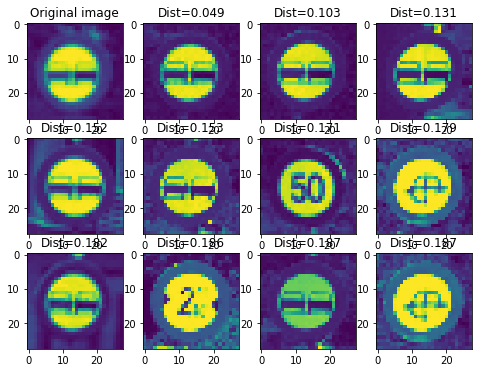

In [20]:
show_similar(x_test[6])